# FaceForensics Video Classification using InceptionV3

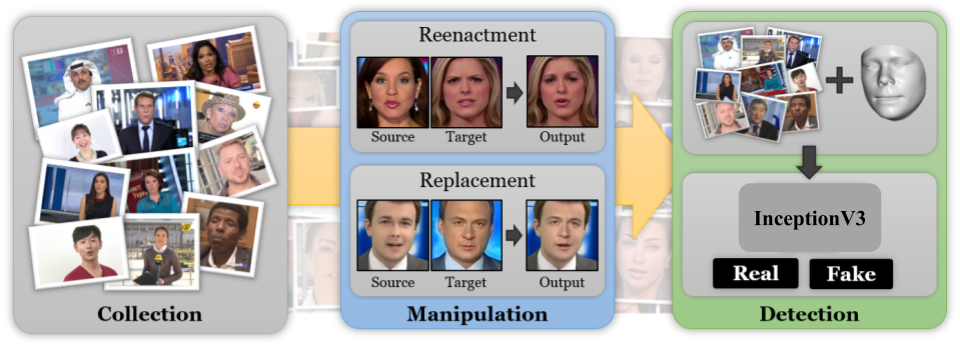

The FaceForensics dataset comprises of 1000 videos which have been manipulated with various face manipulation methods. To classify these videos as real or fake, we will extract frames from the videos so that we can simplify part of this task to an image classification task

## Data preprocessing
Preparing data to train InceptionV3

### Extracting video frames

>> 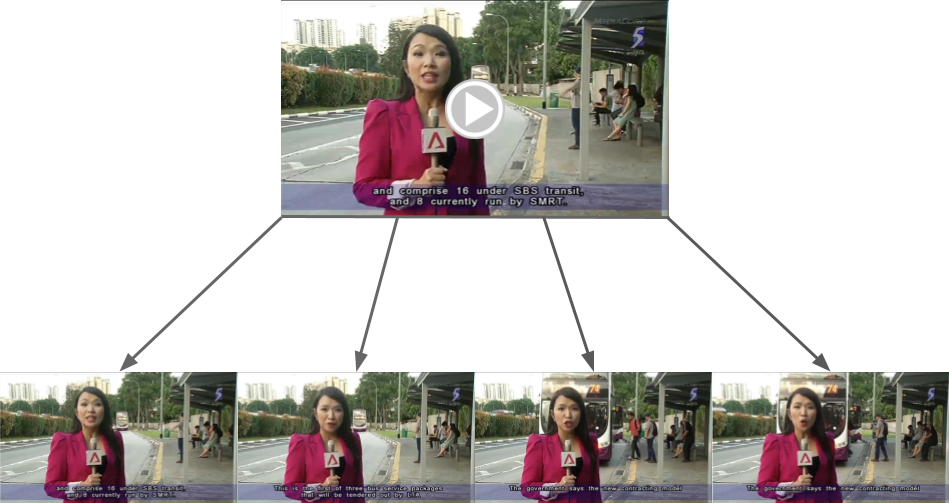

### Face Extraction

> 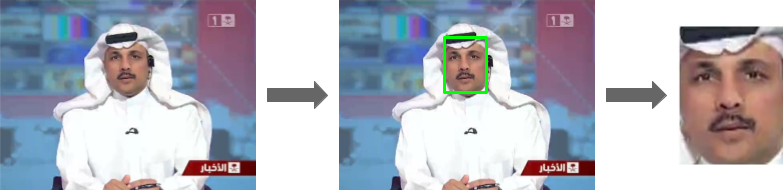

### Data Augmentation

> The FaceForensics dataset contains 5 times more deepfake videos than real videos, leading to dataset imbalance. This is a problem as our model could overfit on the data, for example, by classifying all frames extracted as fake. To resolve this problem, data augmentation can be employed.

> Data augmentation can increase the amount of data we have in the real class by adding slightly modified copies of the existing samples. In this case, we have added greyscale versions of the existing real images and extracted frames at a higher framerate from the real videos to augment the dataset. Other simple methods for data augmentation include random crops of the images, mirroring the images, colour modifications etc. More complex methods include using [Generative Adversarial Networks (GANs)](#GANs) to generate more images.

> 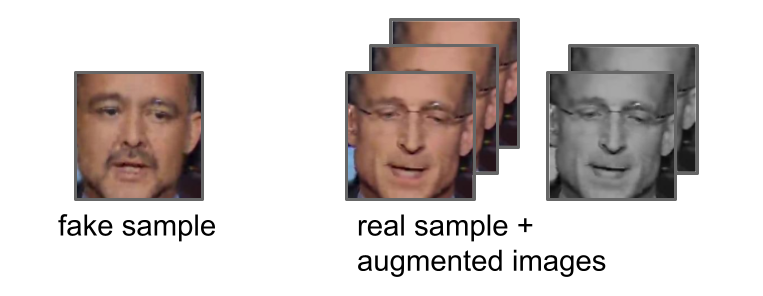

## Classifier

We will be using InceptionV3, which has been pretrained on the ImageNet dataset, to classify the frames extracted from the FaceForensics video dataset

# 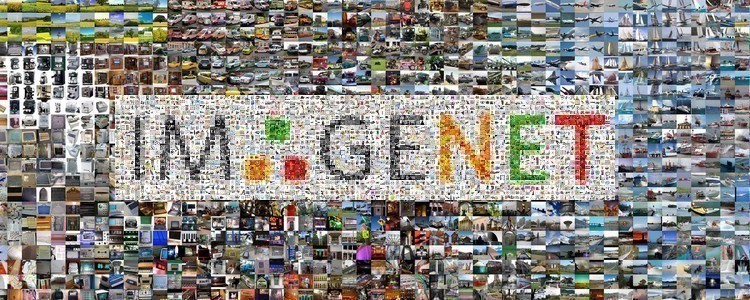

## Import libraries

In [1]:
import numpy as np # for processing of arrays
import pandas as pd
import sklearn # to display model performance on test set
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt # to display images from dataset
import os
from glob import glob
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

# import tensorflow backend and keras api
import tensorflow as tf
import keras
import keras.backend as K

# import model layers and InceptionV3 architecture
from keras.models import Model
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.ensemble import RandomForestClassifier

# import optimizers and callbacks
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

## Check if CUDA is available
CUDA is a parallel computing platform which can speed up our computations (i.e. train this model much faster!) and can be used on any Nvidia GPU from the G8x series onwards.

If CUDA is unavailable, check that your runtime has been changed to GPU. (Runtime -> Change runtime type -> GPU)

In [ ]:
print("GPU Available:", tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None), "\nCUDA Enabled:", tf.test.is_built_with_cuda(), "\nGPU Name:", tf.test.gpu_device_name(), "\nVisible Devices:", tf.config.experimental.list_physical_devices('GPU'))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: True 
CUDA Enabled: True 
GPU Name: /device:GPU:0 
Visible Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 593231381916029219
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5741327008797822640
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


## Download dataset

In [2]:
!wget -nv --show-progress -O ff.zip https://bit.ly/3w0xyBl
!unzip -q ff.zip -d ffdata
!rm ff.zip

ff.zip              100%[===================>]   1.75G  65.0MB/s    in 47s     
2021-05-14 07:37:51 URL:https://liuonline-my.sharepoint.com/personal/jinye735_student_liu_se/Documents/Brain%20Hack%202021/ff.zip?originalPath=aHR0cHM6Ly9saXVvbmxpbmUtbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvamlueWU3MzVfc3R1ZGVudF9saXVfc2UvRVlGNmJjSFdrTUZHckpOYUhmanR3ZWtCUmtFNDBMR3F3Ul9jSWNzeEMyZy1ldz9ydGltZT16S1Y3RWFzVzJVZw [1881286081/1881286081] -> "ff.zip" [1]


In [3]:
# ImageDataGenerator loads images into memory in batches of specified size (in this case 16 images per batch)
# this avoids possible memory issues
train_folder = '/content/ffdata/train'
val_folder = '/content/ffdata/val'
df_train = pd.read_csv(train_folder + '/image_labels.csv')
df_val = pd.read_csv(val_folder + '/image_labels.csv')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # rescaling normalizes pixel values from the range [0,255] to [0,1]
train_set = datagen.flow_from_dataframe(dataframe=df_train, directory=train_folder, classes= ['real', 'fake'], class_mode="categorical", target_size=(299, 299), batch_size=16)
val_set = datagen.flow_from_dataframe(dataframe=df_val, directory=val_folder, classes= ['real', 'fake'], class_mode="categorical", target_size=(299, 299), batch_size=16)

print("Check class name mapping to label index:")
print(train_set.class_indices)
print(val_set.class_indices)

Found 66722 validated image filenames belonging to 2 classes.
Found 12592 validated image filenames belonging to 2 classes.
Check class name mapping to label index:
{'fake': 0, 'real': 1}
{'fake': 0, 'real': 1}


## Model architecture

InceptionV3 is a convolutional neural network, meaning that it extracts features (in this case, faces and facial features) from input images using matrix operations (convolutions)

### Common Layers used in InceptionV3

#### Convolutional Layer (Conv2D)

> A kernel/filter is applied over the input image to obtain a feature map as output

>>>> 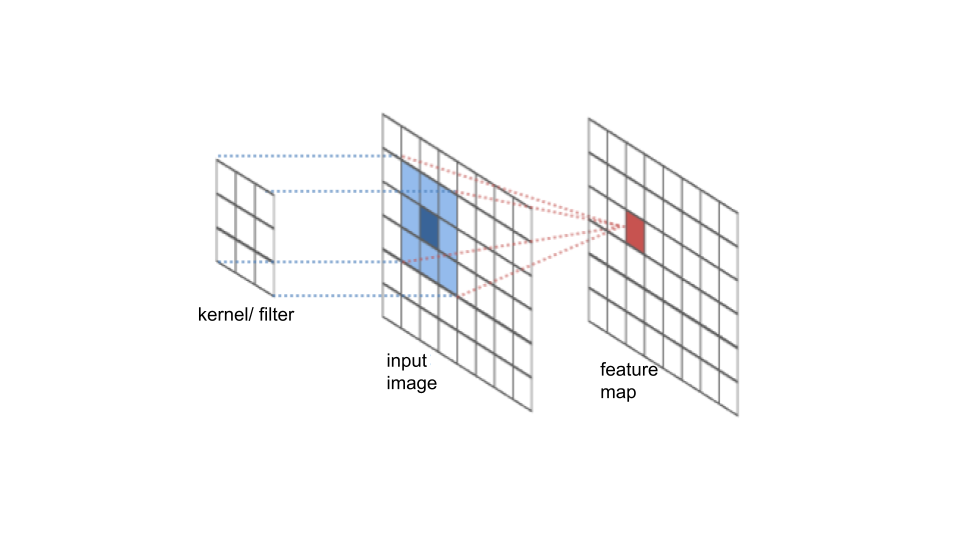

> The filter (in dark blue) is moved over the input image to obtain the feature map (white) as shown below

>>>> 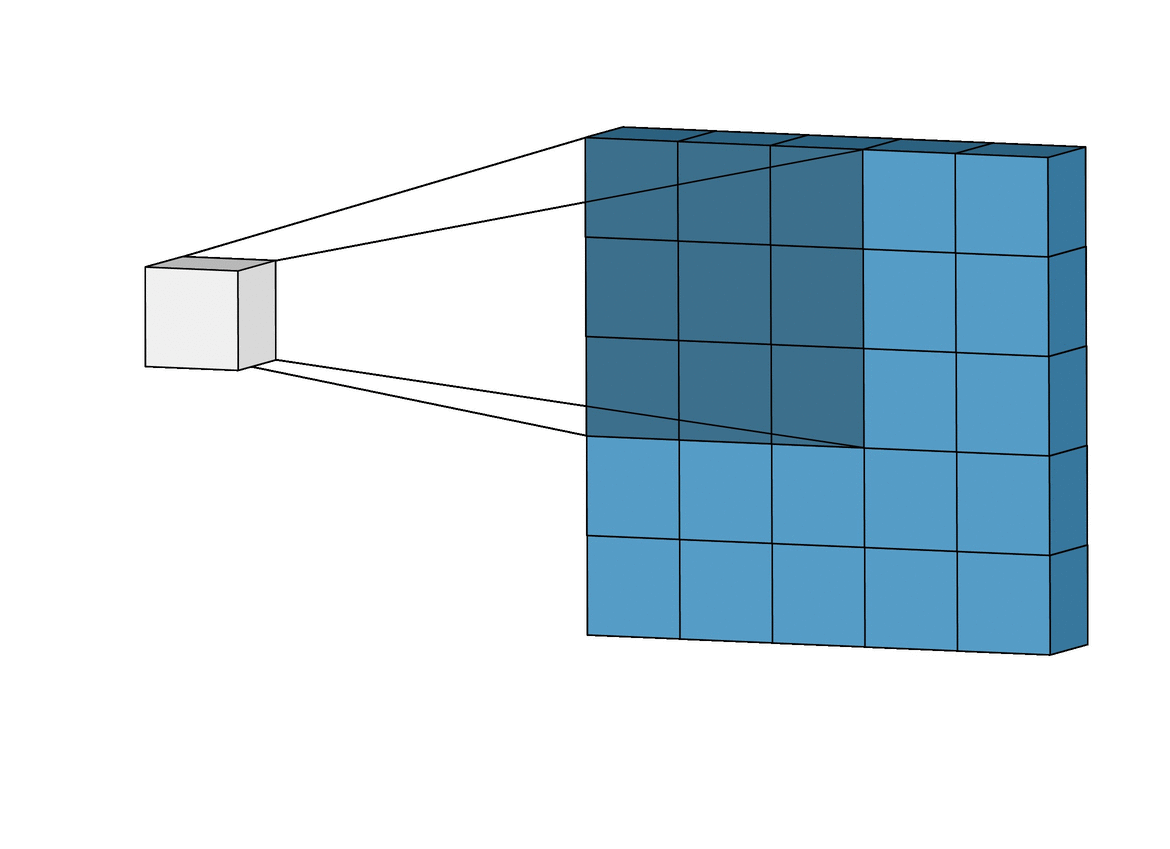

> After the image passes through multiple convolutional layers, feature extraction becomes more complex

> 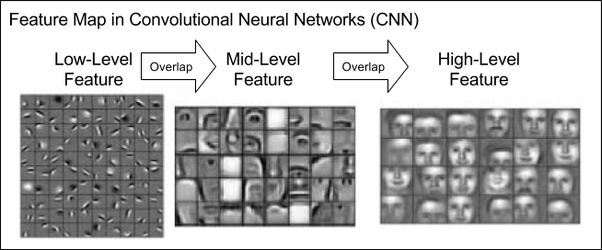

#### Activation Layer (Activation)

> Transforms the input from the node into activation/non-activation of the node. A node is where a computation occurs, so convolutions would occur in a node, and the weighted output of the convolutional layer (feature map) would be the input into the activation layer

>> 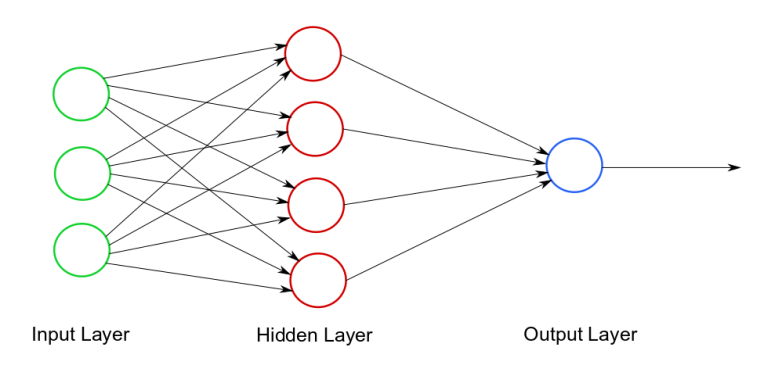

> Note: the hidden layer includes all layers in the model that are not the input or output layers, e.g. convolution and activation layer

> The activation layer uses activation functions, which reside within hidden and output nodes (red and blue circles above), to determine whether to activate the hidden node it is in or not. InceptionV3 uses the [ReLU (Rectified Linear Unit)](#ReLU) activation function.

#### Pooling Layer (MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D)

> Pooling layers help to address limitations of convolutional layers - convolutional layers record the exact position of features in a feature map, so slight shifts in position of the same feature would result in a different feature map. To address this, pooling layers downsample the image (generate a lower resolution version of the feature map).

> Pooling layers
*   Halves size of image by increasing stride length (number of pixels that the filter shifts over the image/feature map each time)
*   Downsamples feature maps, making the resulting feature maps more robust to changes in the position of the feature in the image



>Max Pooling Layer
*   Outputs the maximum value for each filter-sized patch of the feature map



> 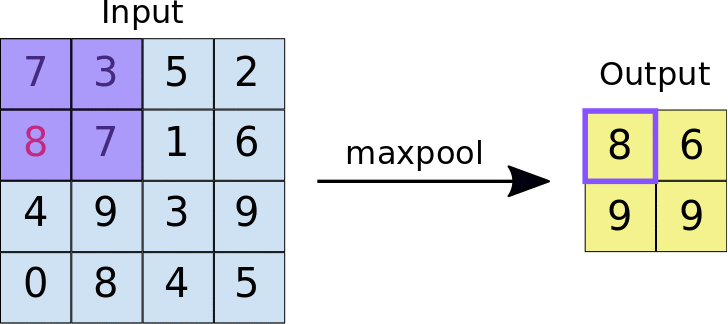

> Average Pooling Layer
*   Outputs the average value for each filter-sized patch of the feature map

> 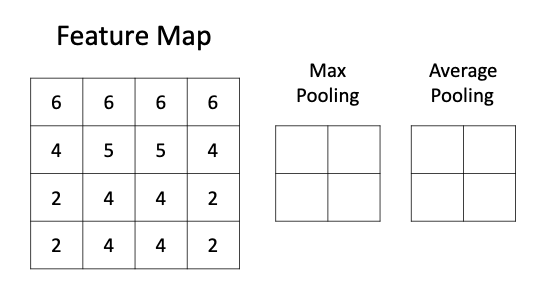

> Global Pooling Layer
*   Downsamples the entire feature map to a single value
*   Used right before output layer

### Load InceptionV3 Pretrained Model
> InceptionV3 documentation: https://keras.io/api/applications/inceptionv3/

In [4]:
base_model = InceptionV3(include_top=False, weights="imagenet", input_tensor=Input(shape=(299,299,3)))
# add global pooling and dense layers to obtain output from the model
layer = base_model
layer = GlobalAveragePooling2D()(layer.output)
layer = Dense(2, activation='softmax', name='output')(layer)
input_layer = base_model.input
model = Model(inputs=input_layer, outputs=layer, name="InceptionV3")

87916544/87910968 [==============================] - 2s 0us/step


In [ ]:
# display model summary
model.summary()

<a name="Optimisers"></a>
### Optimiser
> Updates model in response to output of loss function (loss function tells the model the error in classification of individual samples)

In [5]:
# optimisers from Keras https://keras.io/api/optimizers/#available-optimizers
sgd = SGD(lr=0.001, momentum=0.9, nesterov=False)
adadelta = Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07)
rmsprop = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.9, epsilon=1e-07, centered=False)

#compile model
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

### Inception Module

InceptionV3 is a convolutional neural network using the 3rd iteration of Google's Inception architecture, comprising inception modules which allow it to achieve high classification accuracy at low computation time 

These inception modules perform convolutions with different filter sizes in parallel, stacking the output from all these convolutions together as output

Allows for more efficient computation (shorter training time)

>>>>>> 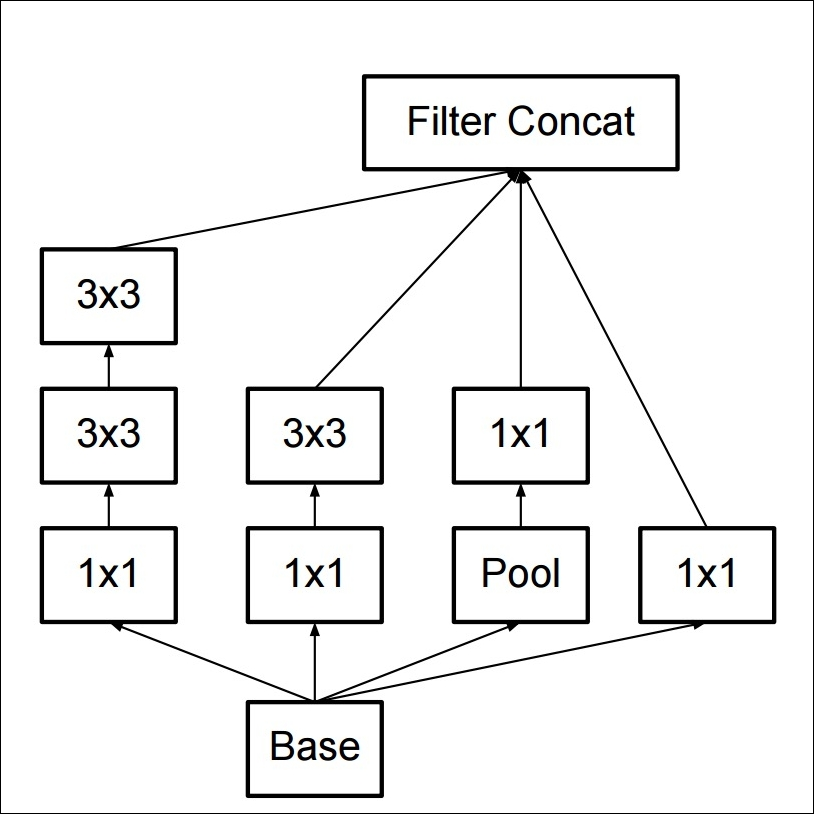

See if you can spot an inception module in the diagram below!

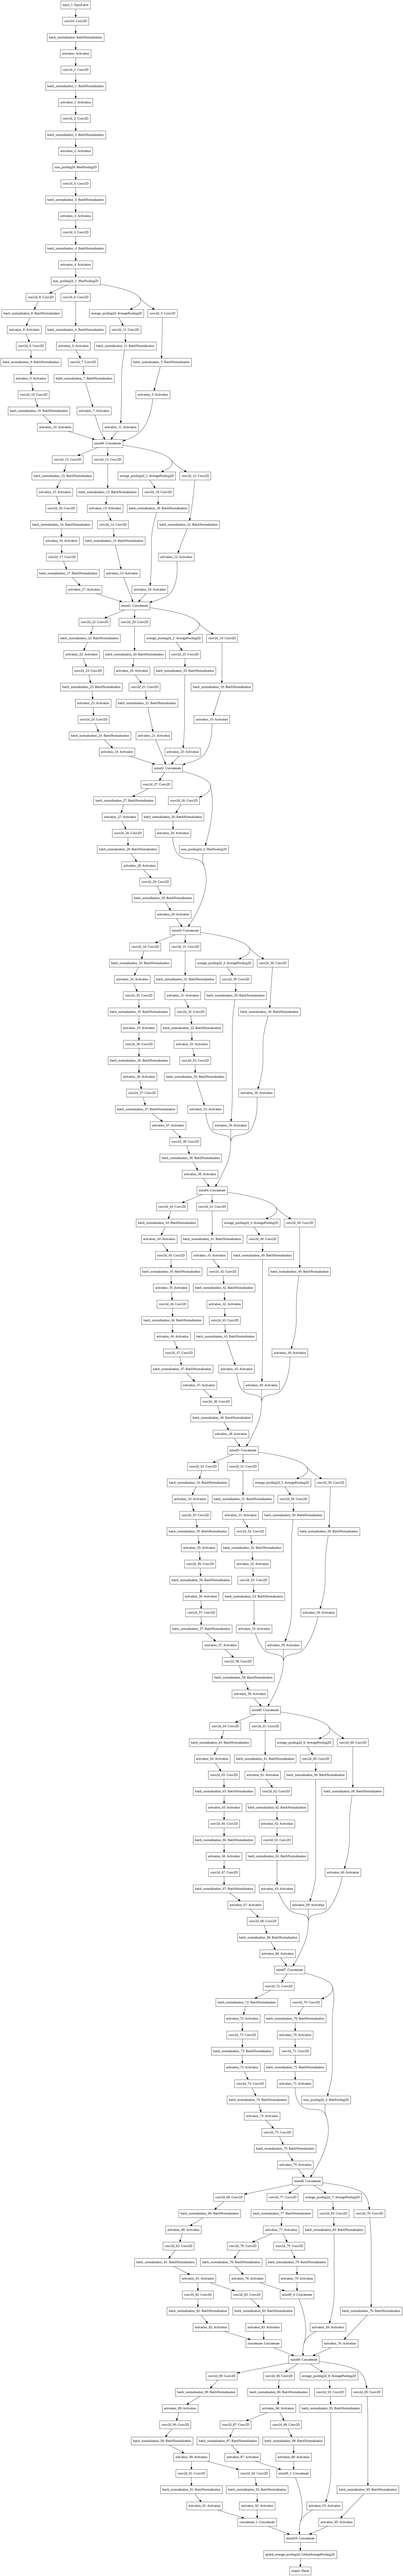

In [ ]:
plot_model(model, to_file='model.png')

## Define callbacks

In [6]:
!mkdir "/content/weights/"

In [7]:
# ModelCheckpoint callback saves the model weights after every epoch (iteration through the dataset)
# if the validation accuracy is higher than that of the model previously saved
checkpoint = ModelCheckpoint("/content/weights/inceptionv3.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

## Train model
> Fit the model to the data

In [8]:
hist = model.fit(train_set, steps_per_epoch=16, epochs = 25, validation_data=val_set, validation_steps=8, callbacks = [checkpoint])

Epoch 1/25
16/16 [==============================] - 46s 344ms/step - loss: 0.5056 - accuracy: 0.8352 - val_loss: 0.5503 - val_accuracy: 0.7891

Epoch 00001: val_loss improved from inf to 0.55030, saving model to /content/weights/inceptionv3.h5
Epoch 2/25
16/16 [==============================] - 4s 252ms/step - loss: 0.4967 - accuracy: 0.8287 - val_loss: 0.4351 - val_accuracy: 0.8516

Epoch 00002: val_loss improved from 0.55030 to 0.43510, saving model to /content/weights/inceptionv3.h5
Epoch 3/25
16/16 [==============================] - 4s 253ms/step - loss: 0.4865 - accuracy: 0.8119 - val_loss: 0.5022 - val_accuracy: 0.7969

Epoch 00003: val_loss did not improve from 0.43510
Epoch 4/25
16/16 [==============================] - 4s 253ms/step - loss: 0.4808 - accuracy: 0.8066 - val_loss: 0.4044 - val_accuracy: 0.8594

Epoch 00004: val_loss improved from 0.43510 to 0.40443, saving model to /content/weights/inceptionv3.h5
Epoch 5/25
16/16 [==============================] - 4s 256ms/step - 

## Display model training/validation accuracy and loss

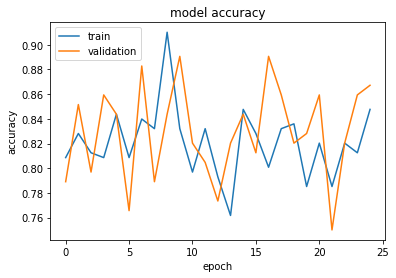

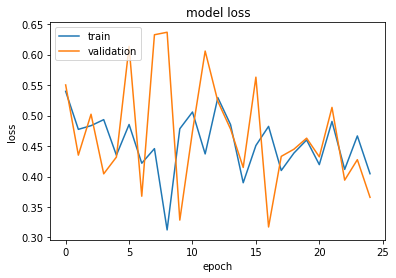

In [9]:
# plot training and validation accuracy against epochs using matplotlib
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plot training and validation loss against epochs using matplotlib
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Load Weights

In [10]:
model.load_weights("/content/weights/inceptionv3.h5")

<a name="eval"></a>
## Evaluate Model

To classify the video as real or fake, we will first obtain the model's predictions on each frame extracted from the video. We will then obtain the mean and median of the probabilities predicted for each frame and pass this data into the Random Forest classifier for it to obtain the prediction of real/fake.

In [12]:
# This function will return us a list of the mean and median probabilities predicted for each video and the video names
# Note that when we use the method .predict(), it returns a list of probabilities that the frame belongs to a certain class
# in this case it returns a list of length 2 since the classes are real and fake
import statistics
def prob(framePath, csv_dir, numUB):
  num = 0
  vidCheck = []
  vidList = []
  predict = []
  prob = []
  # list_dir = os.listdir(framePath)
  list_dir = list(pd.read_csv(framePath + csv_dir).iloc[:,0])
  # list_dir = sorted(list_dir)
  # print(list_dir)
  for file in list_dir:
    # obtain the name of the video that each frame came from
    # naming convention: [video name]-frame[frame number]-[count].jpg
    # naming convention: [fake/real-image]/[video name]/[frame number].jpg
    # vidname = file.split("-")[0]
    vidname = "/".join(file.split("/")[1:])
    vidCheck.append(vidname)
    # load image and normalize pixel values
    img = keras.preprocessing.image.load_img(framePath + file, target_size=(299,299,3))
    img = keras.preprocessing.image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)
    # make predictions based on each frame
    if num == 0:
      vidList.append(vidname)
      prediction = model.predict(img)
      predict.append(prediction[0])
      num += 1
    # if the frame belongs to the same video add the model prediction to the list predict
    elif vidCheck[len(vidCheck)-2] == vidCheck[len(vidCheck)-1]:
      prediction = model.predict(img)
      predict.append(prediction[0])
    # if the frame belongs to the next video we find the mean and median
    # of the probabilities predicted by the model on the previous video 
    # before predicting
    else:
      fake_prob = []
      real_prob = []
      print(predict)
      for i in predict:
        fake_prob.append(i[0])
        real_prob.append(i[1])
      # find mean and median of probabilities predicted by model
      fake_mean = statistics.mean(fake_prob)
      fake_median = statistics.median(fake_prob)
      real_mean = statistics.mean(real_prob)
      real_median = statistics.median(real_prob)
      prob.append([fake_mean, fake_median, real_mean, real_median])
      print(prob)
      print(len(prob))
      predict = []
      num += 1
      if num > numUB:
        break
      # make prediction on frame from new video
      prediction = model.predict(img)
      predict.append(prediction[0])
      vidList.append(vidname)
  if num < numUB:
    fake_prob = []
    real_prob = []
    for i in predict:
      fake_prob.append(i[0])
      real_prob.append(i[1])
    fake_mean = statistics.mean(fake_prob)
    fake_median = statistics.median(fake_prob)
    real_mean = statistics.mean(real_prob)
    real_median = statistics.median(real_prob)
    prob.append([fake_mean, fake_median, real_mean, real_median])
  # print(vidList)
  return vidList, prob


In [ ]:
# def prob(file_path, file_name, len_of_file)
test_vidNames, X_test = prob("/content/ffdata/test/", "image_labels.csv", 1000)

In [22]:
print(len(test_vidNames), len(X_test)) #50, 50

1000 1000


In [23]:
vids = [test_vidNames[i].split('/') for i in range(len(test_vidNames))]
vid_num = [vids[i][0] for i in range(len(vids))]
frame_num = [vids[i][1] for i in range(len(vids))]

In [24]:
prediction = []
vid_id = []
i = 0
while i < len(vids):
    total, count = 0, 0
    currVid = vid_num[i]
    while i < len(vids) and vid_num[i] == currVid:
        total += X_test[i][2]
        count += 1
        i += 1
    prediction += [total/count]
    vid_id += [currVid]

In [25]:
modelPredictions = pd.DataFrame()
modelPredictions["vid_name"] = vid_id
modelPredictions["label"] = prediction
modelPredictions.vid_name = modelPredictions.vid_name.astype("str")
# %cd "/content/drive/My Drive/Brainhack FaceForensics Dataset"
modelPredictions.to_csv("/content/ffdata/model_predictions.csv", index=False)

## Submission

Sumission link:

### Frame Extraction

In [ ]:
def extract_frames(vidPath, savePath):
  for file in os.listdir(vidPath):
    count = 0
    cap = cv2.VideoCapture(vidPath + file)
    frame_rate = 3
    prev = 0
    i = 0
    while cap.isOpened():
      time_elapsed = time.time() - prev
      ret, frame = cap.read()
      if not ret:
        break
      if time_elapsed > 1./frame_rate:
          prev = time.time()
          os.chdir(savePath)
          filename = file + "-frame%d.jpg" % count;count+=1
          cv2.imwrite(filename, frame)
          i += 1
    cap.release()
    cv2.destroyAllWindows()

extract_frames("/content/drive/My Drive/Brainhack FaceForensics Dataset/test/Videos",
               "/content/drive/My Drive/Brainhack FaceForensics Dataset/test/extract_frames")

### Face Extraction

In [ ]:
def extF(imgPath, savePath):
    for file in os.listdir(imgPath):
        face_detector = dlib.get_frontal_face_detector()
        image = io.imread(imgPath + file)
        detected_faces = face_detector(image, 1)
        face_frames = [(x.left(), x.top(), x.right(), x.bottom()) for x in detected_faces]
        count = 0
        for n, face_rect in enumerate(face_frames):
            os.chdir(savePath)
            face = Image.fromarray(image).crop(face_rect)
            image = np.asanyarray(face)
            filename = file + "-" + str(count) + ".jpg"
            io.imsave(filename, image)
            count += 1
            break

extF("/content/drive/My Drive/Brainhack FaceForensics Dataset/test/extract_frames", 
     "/content/drive/My Drive/Brainhack FaceForensics Dataset/test/extract_faces")

In [ ]:
# # use keras .predict method to obtain the model's predicted probabilities on each frame for each class
# pred = model.predict(test_set)
# y_predFr = pred
# # obtain the true class of each frame
# y_trueFr = test_set.classes[test_set.index_array]

In [ ]:
# pred = []
# # obtain the class predicted for each frame from probabilities predicted by the model
# for l in range(len(y_predFr)):
#   pred.append(np.argmax(y_predFr[l], axis = 0))
# # get precision, recall and f1-scores for each class
# # to determine if the model is overfitting
# print(classification_report(y_trueFr, pred, target_names=['fake', 'real']))
# # get confusion matrix
# print(confusion_matrix(y_trueFr, pred))
# # get accuracy score
# print("Accuracy: ", accuracy_score(y_trueFr, pred))

              precision    recall  f1-score   support

        fake       0.00      0.00      0.00     12949
        real       0.45      1.00      0.62     10548

    accuracy                           0.45     23497
   macro avg       0.22      0.50      0.31     23497
weighted avg       0.20      0.45      0.28     23497

[[    0 12949]
 [    1 10547]]
Accuracy:  0.4488658126569349


Labels for sklearn confusion matrix (negative corresponds to fake images)

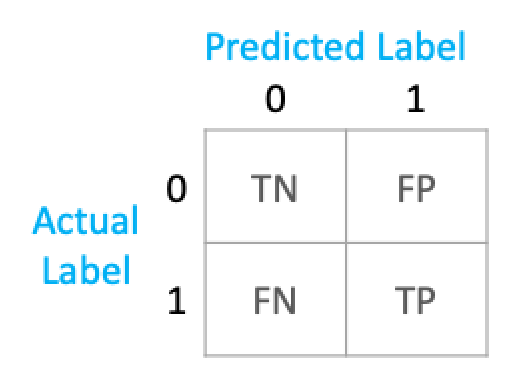

In [ ]:
# # evaluate model
# results = model.evaluate(test_set)

1469/1469 [==============================] - 230s 156ms/step - loss: 0.8730 - accuracy: 0.4489


In [ ]:
# metrics = model.metrics_names
# # display accuracy and loss for model.evaluate
# for i in range(len(metrics)):
#   print(metrics[i], ":", results[i])

loss : 0.8730071187019348
accuracy : 0.4488658010959625


## Try to achieve the highest accuracy you can!
> Possible things to try:
*   [Hyperparameter tuning](https://towardsdatascience.com/what-are-hyperparameters-and-how-to-tune-the-hyperparameters-in-a-deep-neural-network-d0604917584a) (e.g. number of epochs, batch size etc.)
*   Using different optimisers and tuning their parameters (sgd, adadelta and rmsprop have been included in the code [above](#Optimisers)
*   Using [callbacks](https://keras.io/api/callbacks/#available-callbacks)

## Submit for judging
> Run the cells under [Evaluate Model](#eval) and send the output to your mentor

# Advanced Topics (Optional)

## GANs
<a name="GANs"></a>

>GANs comprise of 2 sub models - the discriminator and generator. The generator aims to generate samples that can fool the discriminator into thinking they are real samples. Over time, the discriminator is unable to distinguish between the real and generated samples, so the discriminator accuracy converges to 50% (no better than randomly guessing classes). Further reading: https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/

> State of the art GAN models such as Nvidia StyleGAN2 are able to generate realistic faces. Visit [This Person Does Not Exist](https://thispersondoesnotexist.com/) to see faces generated by this GAN.

> Some faces generated by StyleGAN:

> 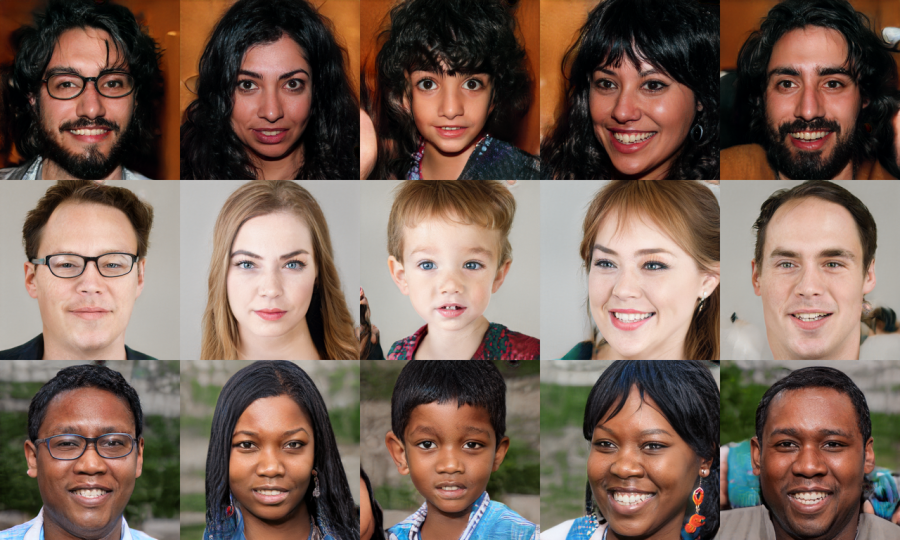

## Activation Layers

> ReLU (Rectified Linear Unit)
<a name="ReLU"></a>

> 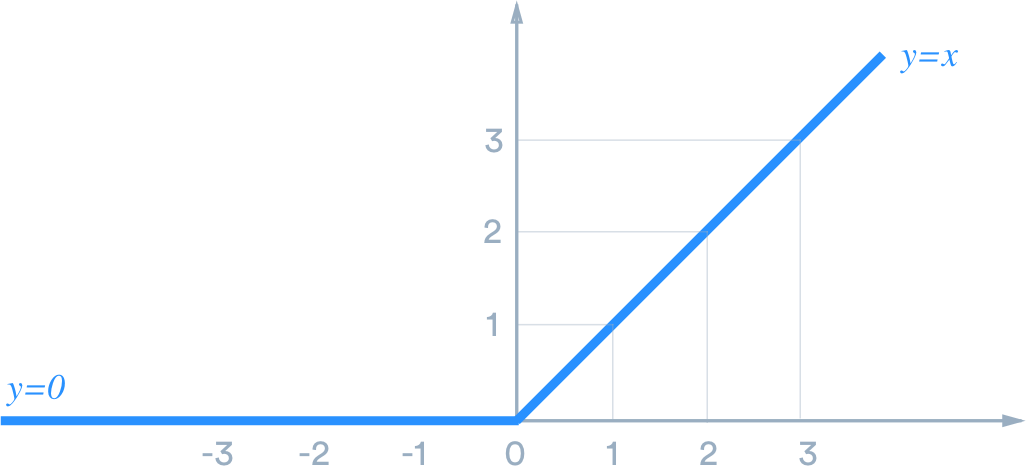

> ReLU is used to combat the vanishing gradient problem due to the limitations of Sigmoid and Tanh activation functions. Further reading: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e

## Optimisers
> Further reading: https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6

> SGD (Stochastic Gradient Descent)
1.   Calculates what a small change in each individual weight would do to the loss function
2.   Adjust individual weight based on gradient of batches/ random samples
3.   Repeat above steps to minimize loss function

> Adam (Adaptive Moment Estimation)
*   Uses past gradients to calculate current gradients
*   Uses concept of momentum by adding fractions of previous gradients to the current one

> Adadelta
*   adapts learning rate to individual features
*   some weights will have different learning rates than others
*   works well for sparse datasets where a lot of input examples are missing
*   adaptive learning rate gets extremely small over time

> RMSprop
*   keeps the moving average of the squared gradients for each weight, divide the gradient by square root the mean square
*   Further reading: https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a